In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids, get_sample_id_mask
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")



adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

# Change the run_name variable to select the appropriate iteration
run_name = '20230908'




In [21]:
# Added 13.12.2023
# Rename some of the more ambiguous cell names
# NOT YEAT IMPLEMENTED IN THE UPPER PART OF THIS SCRIPT (plotting etc.)

cell_type_renaming_dict = {
    'mesenchymal epithelium':'sensescent epithelium',
    'interferon signaling epithelium':'club_interferon response epithelium',
    'cancer epithelium':'tumor',
    'intermediate CRPC epithelium':'cycling epithelium 1',
    'cycling epithelium':'cycling epithelium 2',
    'FOSL1 tumor epithelium':'FOSL1 related epithelium',
    'fibroblasts':'fibroblast'
    }


#cell_mapping_dat.var.index = pd.Index(pd.Series(cell_mapping_dat.var.index).replace(cell_type_renaming_dict))

In [22]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_'+run_name+'.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']



## Visium mapping plots

In [27]:
# Plots and saves top n_types with highest prevelance on visium slides
n_types = 12

for sample in samples:
    slide = adata_slides[sample]

    # Added 13.12.2023
    slide.obs.columns = pd.Index(pd.Series(slide.obs.columns).replace(cell_type_renaming_dict))

    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

<Figure size 1537.92x1080 with 0 Axes>

In [ ]:
## Side by side violin plots of abundant cell types + spatial 

plt.rcParams.update({'axes.titlesize': 'small'})

n_types = 6
obs_name = 'joint_leiden_clusters'

for s in samples:

    slide = adata_slides[s].copy()

    # Subset to only plot the cell types with highest mean prevalence
    cell_counts = slide.obs[adata_vis.uns['mod']['factor_names']]
    cell_type_pcts = cell_counts.div(cell_counts.sum(axis=1),axis=0)*100
    cell_types_to_plot = cell_type_pcts.mean(axis=0).sort_values(ascending=False)[:n_types].index


    # Iterate over the columns of df2
    for column in cell_type_pcts.columns:
        # Check if the column exists in df1
        if column in slide.obs.columns:
            # Replace the column in df1 with the corresponding column from df2
            slide.obs[column] = cell_type_pcts[column]


    fig = plt.figure(figsize=(16,16))

    gs = fig.add_gridspec(6,3)
    ax6 = fig.add_subplot(gs[:, 1:3])

    # Plot the data in the left column subplots
    for i in range(6):

        ax_plotting = fig.add_subplot(gs[i,0])

        sc.pl.violin(slide,groupby=obs_name,keys=cell_types_to_plot[i],jitter=False,rotation=45,inner='box',
                    ax=ax_plotting,show=False)
        
        ax_plotting.yaxis.label.set_size(12)
        ax_plotting.yaxis.label.set_rotation(75)

        if i < 5:  # only remove x-labels for the top 5 subplots on the left
            ax_plotting.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

    sc.pl.spatial(adata_slides[s],color='joint_leiden_clusters',size=1.3,ax=ax6)

    fig.savefig('./plots/c2l_mapping_results_'+run_name+'/'+s+'_cell_type_prevalences_per_cluster.png')
    plt.clf()



## Secondary analysis of the cell type mapping numbers

In [ ]:
# Save the cell mapping data into an array
""" 
cell_types = list(adata_vis.uns['mod']['factor_names'])
ctype_dat = np.array(adata_vis.obs[cell_types].copy())
ctype_dat_obs = adata_vis.obs.drop(columns=cell_types).copy()
ctype_dat_var = pd.DataFrame(index=cell_types)
cell_mapping_dat = ad.AnnData(X=ctype_dat,obs=ctype_dat_obs,var=ctype_dat_var)

cell_mapping_dat.write('c2l_mapping_as_anndata_'+run_name+'.h5ad')
 """

In [61]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_id_mask
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

# Change the run_name variable to select the appropriate iteration
run_name = '20230908' # 20230908 is the 26-cell type reference mapped onto spatial

cell_mapping_dat = sc.read_h5ad('c2l_mapping_as_anndata_'+run_name+'.h5ad')
cell_types = list(cell_mapping_dat.var_names)


In [92]:
# Added 13.12.2023
# Rename some of the more ambiguous cell names

cell_type_renaming_dict = {
    'mesenchymal epithelium':'sensescent epithelium',
    'interferon signaling epithelium':'club_interferon response epithelium',
    'cancer epithelium':'tumor',
    'intermediate CRPC epithelium':'cycling epithelium 1',
    'cycling epithelium':'cycling epithelium 2',
    'FOSL1 tumor epithelium':'FOSL1 related epithelium',
    'fibroblasts':'fibroblast'
    }


cell_mapping_dat.var.index = pd.Index(pd.Series(cell_mapping_dat.var.index).replace(cell_type_renaming_dict))

In [93]:
# format the observations to show BPH-TRNA-NEADT-CRPC divide

df = pd.DataFrame(cell_mapping_dat.X, columns=cell_mapping_dat.var.index,index=cell_mapping_dat.obs.index)
sample_id_masks = get_sample_id_mask()

sample_indices_from_df = pd.Series([('_').join(s.split('_')[:-1]) for s in df.index])
df.index = pd.Index(list(sample_indices_from_df.map(sample_id_masks)))


In [82]:
# Save the key cell-type mapping numbers to an excel file (supplementary table)

cell_mapping_characteristics_by_phenotype = {}

phenotypes = ['','BPH','TRNA','NEADT','CRPC']

for phenotype in phenotypes:
    ctype_count_df = df.loc[df.index.str.contains(phenotype)].describe().T

    ctype_count_df['sum'] = df.loc[df.index.str.contains(phenotype)].sum().loc[ctype_count_df.index].astype(float)
    ctype_count_df = ctype_count_df[['sum','mean','min','25%','50%','75%','max','std','count']].round(1)
    ctype_count_df = ctype_count_df.sort_values('sum',ascending=False)
    
    if phenotype == '':
        cell_mapping_characteristics_by_phenotype['all'] = ctype_count_df
    else:
        cell_mapping_characteristics_by_phenotype[phenotype] = ctype_count_df

# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/inferred_cell_type_counts_key_statistics.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in cell_mapping_characteristics_by_phenotype.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()
    

In [98]:
from scipy.stats import f_oneway

inferred_tumor_counts_dict = {}
for phenotype in ['BPH','TRNA','NEADT','CRPC']:
    inferred_tumor_counts_dict[phenotype] = df.loc[df.index.str.contains(phenotype)]['tumor'].tolist()

f_stat, pval = f_oneway(*inferred_tumor_counts_dict.values())

In [99]:
pval

0.0

### Run NMF to divide into significantly variable regions

In [100]:
# Run NMF to find 'tissue regions'
nmf_res_dict = {}
nmf_cell_weights_dict = {}
adata = cell_mapping_dat.copy()

# Set the range of components
component_range = range(5, 13)

# Perform NMF
for n_components in component_range:
    nmf = NMF(n_components=n_components,random_state=3456372)
    W = nmf.fit_transform(adata.X)
    H = nmf.components_

    nmf_res = pd.DataFrame(H.T,
                        index=adata.var_names,
                        columns=list(np.arange(0,n_components)+1),)

    nmf_res_dict[n_components] = nmf_res
    nmf_cell_weights_dict[n_components] = W

In [108]:
df = pd.DataFrame(cell_mapping_dat.X, columns=cell_mapping_dat.var.index,index=cell_mapping_dat.obs.index)
celltype_order = df.sum().sort_values(ascending=True).index

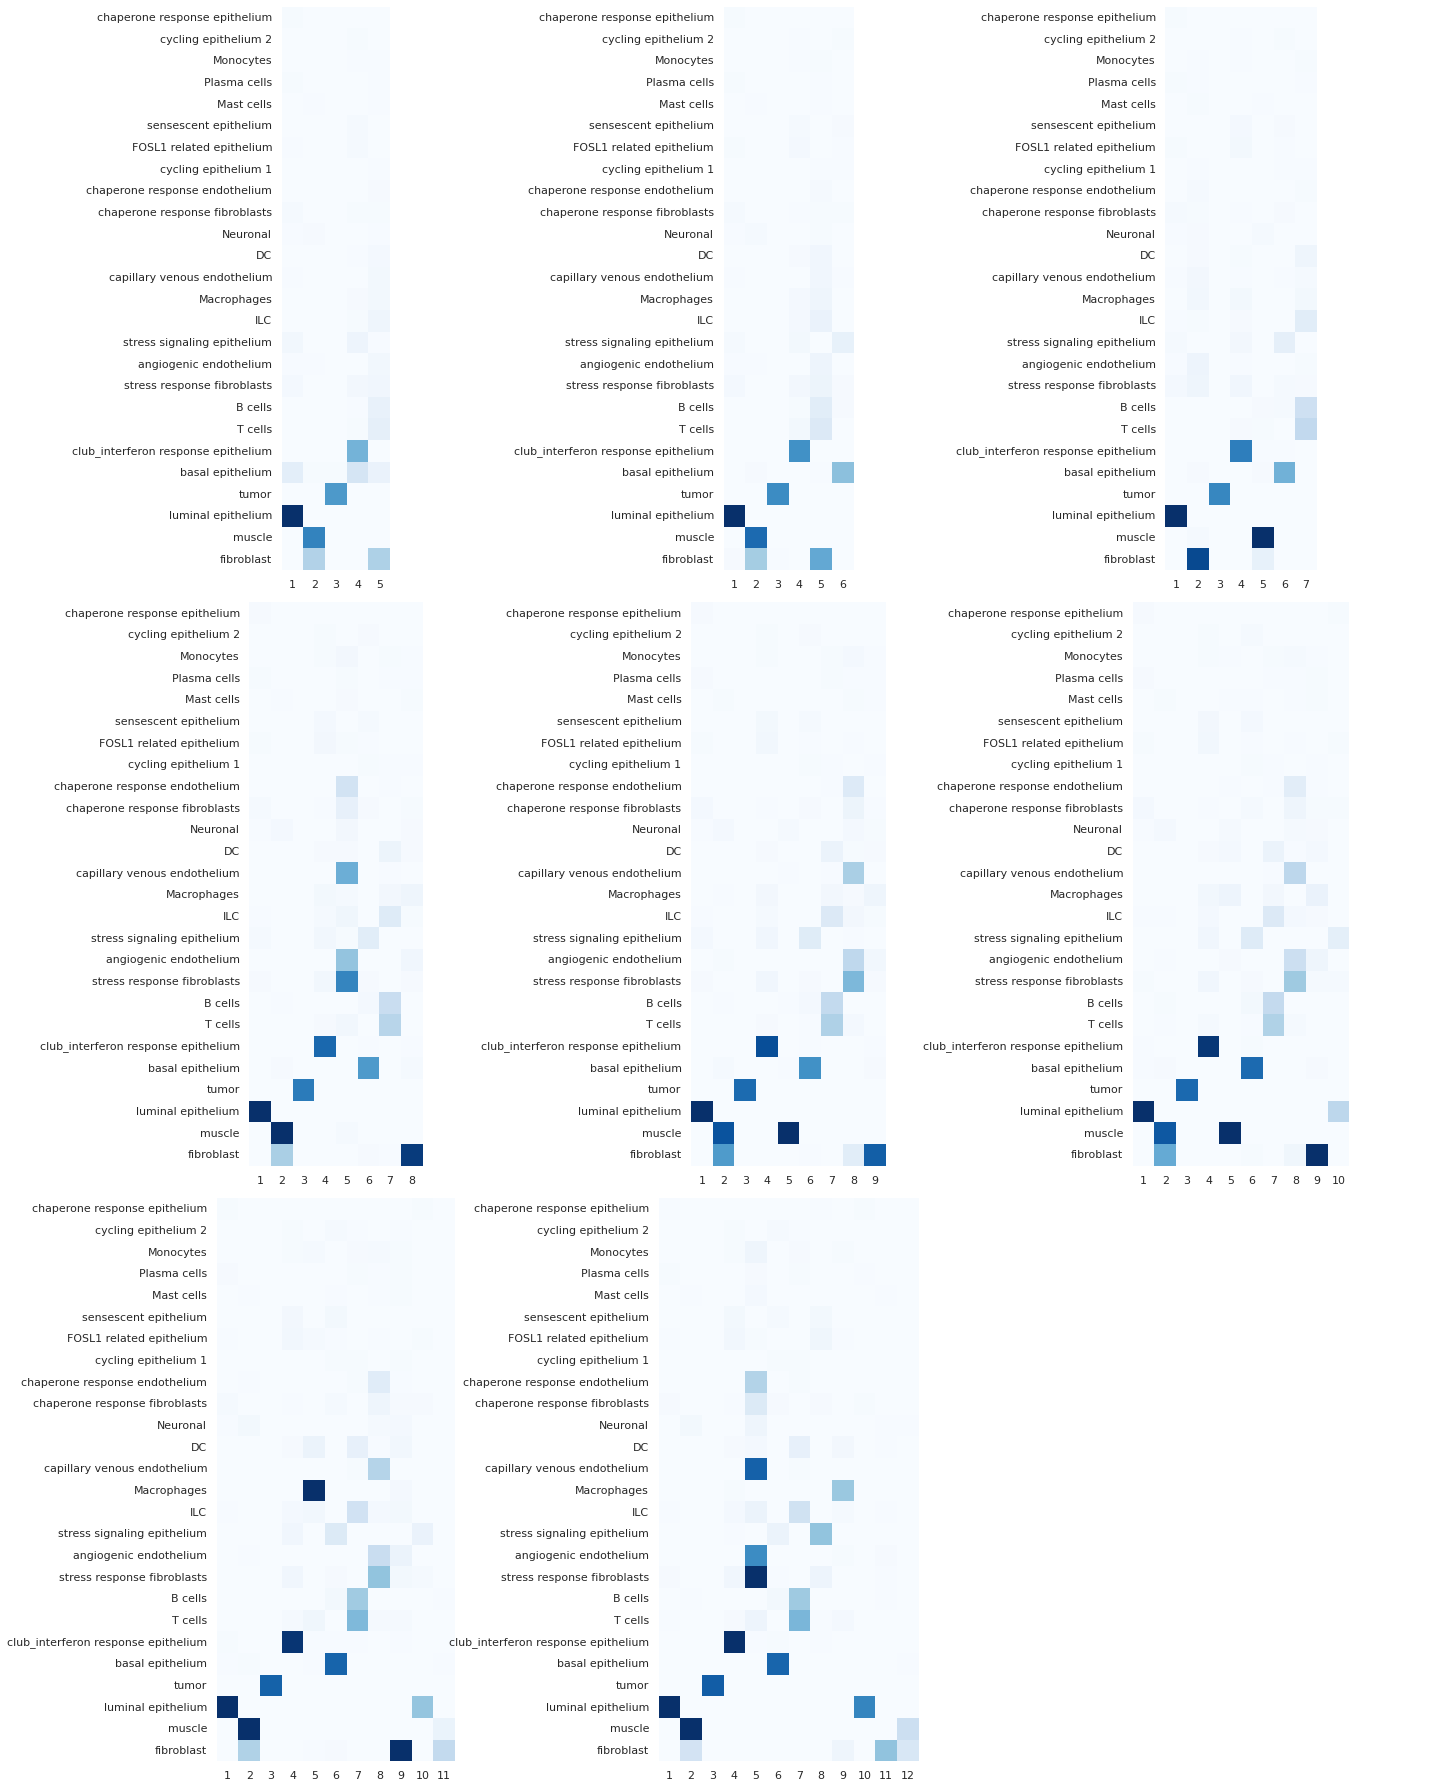

In [110]:
# Plot the nmf results on two rows
# Create subplots with 2 rows and 4 columns
sns.set_theme(style='white',font_scale=1)
fig, axs = plt.subplots(3, 3, figsize=(20, 25))

for i, n_components in enumerate(component_range):

    nmf_res_for_plotting = nmf_res_dict[n_components].copy()
    nmf_res_for_plotting = nmf_res_for_plotting.loc[celltype_order]

    # Determine the position of the subplot on the grid
    row = i // 3
    col = i % 3
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(nmf_res_for_plotting, cmap='Blues', square=True, ax=axs[row, col], vmax=100,cbar=False)


axs[2,2].axis('off')
plt.tight_layout()

plt.savefig('plots/nmf_components.pdf')
plt.show()


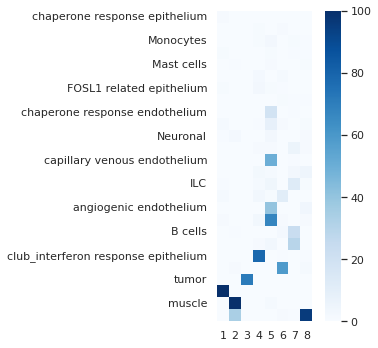

In [111]:
# Plot the nmf results on two rows
# Create subplots with 2 rows and 4 columns
fig, ax = plt.subplots(figsize=(5, 5))

n_components = 8

# Drop the redundant cell types prior to plotting
nmf_res_for_plotting = nmf_res_dict[n_components].copy()
nmf_res_for_plotting = nmf_res_for_plotting.loc[celltype_order]
# Plot the heatmap on the corresponding subplot
sns.heatmap(nmf_res_for_plotting, cmap='Blues', square=True, ax=ax, vmax=100,cbar=True)

plt.tight_layout()

#plt.savefig('plots/nmf_components_with_colorbar.pdf')
plt.show()


In [112]:

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/nmf_component_weights_for_celltypes.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in nmf_res_for_plotting.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.loc[celltype_order].to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()

{5:                                               1          2          3  \
 B cells                                0.000000   0.000000   0.000000   
 DC                                     0.000000   0.000000   0.000000   
 FOSL1 related epithelium               0.775063   0.000000   0.000000   
 ILC                                    0.000000   0.000000   0.000000   
 Macrophages                            0.000000   0.081432   0.077988   
 Mast cells                             0.150154   0.550399   0.024096   
 Monocytes                              0.052321   0.019031   0.000000   
 Neuronal                               0.393999   1.494829   0.000000   
 Plasma cells                           0.871123   0.000000   0.068760   
 T cells                                0.000000   0.000000   0.000000   
 angiogenic endothelium                 0.469833   0.529584   0.007598   
 basal epithelium                       9.930719   1.126632   0.854489   
 tumor                             

### Annotate the NMF factors

In [ ]:
# Select the best number of factors and annotate them
tissue_region_names = {1:'Luminal epithelium', 2:'Muscle', 3:'Tumor', 4:'Intermediate epithelium',
                       5:'Endothelium', 6:'Basal epithelium', 7:'Immune', 8:'Fibroblast'}

# Sorting out the colors for tissue regions (Set2 palette)
sorted_region_names = [np.sort(list(tissue_region_names.values())).tolist()[i] for i in [7,4,0,3,5,1,2,6]]
tissue_region_colors = ['#fc8d62','#8da0cb','#66c2a5','#ffd92f','#a6d854','#e78ac3','#e5c494','#b3b3b3']
region_colors_dict = dict(zip(sorted_region_names,tissue_region_colors))

# Number 8 is the best fit
tissue_regions = nmf_res_dict[8].copy().rename(columns=tissue_region_names)

In [ ]:

# Spot identity is determined by simply choosing the factor with the highest nmf weight
obs_data = cell_mapping_dat.obs.copy().reset_index(drop=True)
nmf_obs_weights = pd.DataFrame(nmf_cell_weights_dict[8],columns=list(tissue_region_names.values()),index=cell_mapping_dat.obs_names)
nmf_obs_annot = nmf_obs_weights.idxmax(axis=1)

obs_data.index = cell_mapping_dat.obs_names
obs_data['nmf_weight_based_regions'] = nmf_obs_annot
nmf_obs_annot.value_counts()


In [ ]:
samples = get_sample_ids()
for sample in samples:
    slide = adata_slides[sample]
    slide.obs['predicted_region'] = obs_data.loc[slide.obs_names]['nmf_weight_based_regions'].astype('category')
    slide_categories = [s for s in sorted_region_names if s in slide.obs['predicted_region'].cat.categories]
    slide.obs['predicted_region'] = slide.obs['predicted_region'].cat.reorder_categories(slide_categories)

    # Get the colors considering some might be missing
    slide.uns['predicted_region_colors'] = [region_colors_dict[region] for region in slide_categories]

    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))
    sc.pl.spatial(slide,color='predicted_region',size=1.3,ax=ax_plotting[0],show=False)
    sc.pl.spatial(slide,color='joint_leiden_clusters',size=1.3,ax=ax_plotting[1],show=False)
    plt.tight_layout()
    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_nmf_obs_weight_based_tissue_regions_spatial.pdf')
    plt.clf()
    

In [ ]:
# This is in ALL samples
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in samples:
    
    slide = adata_slides[sample]
    sq.gr.nhood_enrichment(slide, cluster_key='predicted_region',show_progress_bar=False)
    
    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)


    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat
sns.set_theme(style='white')
fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='bwr',ax=ax,annot=True,fmt='.1f',center=0,vmin=-30,vmax=30)
plt.savefig('./plots/tissue_region_interaction_heatmap_all_samples.pdf')
plt.show()

In [ ]:
PCa_samples = get_sample_ids('PCa')
# This is in PCa samples
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in PCa_samples:
    slide = adata_slides[sample]
    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)


    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat

sns.set_theme(style='white')
fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='bwr',ax=ax,annot=True,fmt='.1f',center=0,vmin=-30,vmax=30)
plt.savefig('./plots/tissue_region_interaction_heatmap_PCa_samples.pdf')
plt.show()

In [ ]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_'+run_name+'.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']


In [ ]:
from scripts.utils import save_to_pickle
save_to_pickle(adata_slides,'./data/slides_with_cell_mapping_based_regions.pkl')